# Packets Reception Rate

In [1]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline

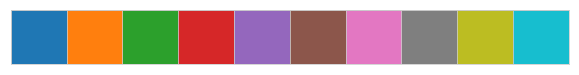

In [2]:
sns.palplot(sns.color_palette())

In [3]:
# deixar a pasta scripts vizivel no notebook
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join('..', 'pyscripts'))
if module_path not in sys.path :
    sys.path.append(module_path)

In [4]:
# import module from scripts folder
import process_data

## Pre processing 

In [5]:
## import dataset from ../data
data_folder = os.path.join('..','Simulations')

# the same file will be searching
main_file = 'packets_reception_rate.txt' 

simulations = ['PA','PB','CL2','CL4','CLBinomial']

DF_DATA = pd.DataFrame()

for folder in simulations:
    data_file = os.path.join(data_folder,folder,main_file)
    df = process_data.parser_main_table(data_file)
#     df = process_data.parser_allvalues_table(data_file)
    df['Simulation'] = folder
    DF_DATA = DF_DATA.append(df,ignore_index=True)

del df

In [6]:
DF_DATA.columns

Index(['info_0', 'info_1', 'index=1', 'index=2', 'index=3', 'index=4',
       'index=5', 'Simulation'],
      dtype='object')

In [7]:
DF_DATA.head()

,info_0,info_1,index=1,index=2,index=3,index=4,index=5,Simulation
0,setRateHigh,InterfModel=0,0.94816,0.9568,0.95314,0.84391,0.82242,PA
1,setRateHigh,InterfModel=2,0.91704,0.95658,0.92449,0.78644,0.74614,PA
2,setRateLow,InterfModel=0,0.98923,0.99889,0.98275,0.99166,0.98178,PA
3,setRateLow,InterfModel=2,0.98468,0.99823,0.97376,0.98736,0.9788,PA
4,setRateMedium,InterfModel=0,0.98569,0.9958,0.97681,0.98862,0.98658,PA


## Normalizando dados

In [8]:
numeric_columns = ['index=1', 'index=2', 'index=3', 'index=4', 'index=5']
DF_DATA[numeric_columns] = DF_DATA[numeric_columns].astype('float')

DF_DATA[numeric_columns] *= 100

In [9]:
taxa_dados = {
    'setRateLow' : 'baixa',
    'setRateMedium': 'média',
    'setRateHigh' : 'alta'
}

packet_rate = {
    'setRateLow' : 'low',
    'setRateMedium': 'medium',
    'setRateHigh' : 'high'
}

def infer_packet_rate(value,mapper=taxa_dados):
    return mapper.get(value,value)

DF_DATA['info_0'] = DF_DATA['info_0'].apply(infer_packet_rate)

In [10]:
modelo_colisao = {
    'InterfModel=0': 'sem colisão',
    'InterfModel=2': 'com colisão'
}

collision_model = {
    'InterfModel=0': 'without collision',
    'InterfModel=2': 'with collision'
}

def infer_collision_model(value,mapper=modelo_colisao):
    return mapper.get(value,value)

DF_DATA['info_1'] = DF_DATA['info_1'].apply(infer_collision_model)

### Renomeando colunas

In [11]:
columns_portuguese = {
        'info_0': 'Taxa de dados',
        'info_1': 'Modelo de colisão',
        'index=1': 'E-Punho',
        'index=2': 'D-Punho',
        'index=3': 'E-Tornozelo',
        'index=4': 'D-Tornozelo',
        'index=5': 'Peito',
        'index=0': 'Sink',
        'Simulation' : 'Simulação'
    }

columns_english = {
        'info_0': 'Packet rate',
        'info_1': 'Collision model',
        'index=1': 'L-wrist',
        'index=2': 'R-wrist',
        'index=3': 'L-ankle',
        'index=4': 'R-ankle',
        'index=5': 'chest',
        'index=0': 'sink'
    }

DF_DATA.rename(mapper=columns_portuguese,axis='columns', inplace=True)

In [12]:
df = DF_DATA.describe()
df

,E-Punho,D-Punho,E-Tornozelo,D-Tornozelo,Peito
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,91.767000,97.634033,88.798367,89.471933,85.652900
std,7.243986,2.301041,10.707786,9.838318,14.586454
min,71.375000,91.581000,60.114000,65.197000,40.961000
25%,90.082000,95.439000,90.111000,83.235750,75.650750
50%,94.786000,98.581500,93.116000,95.494000,94.199500
75%,96.258000,99.549750,95.031750,97.921750,97.454500
max,98.923000,99.889000,98.275000,99.166000,98.658000


In [13]:
value_vars = list(df.columns)
id_vars = set(DF_DATA.columns) - set(df.columns)
id_vars = list(id_vars)

In [14]:
melted_data = DF_DATA.melt(id_vars=id_vars,
                     value_vars=value_vars,
                     value_name='PRR',
                     var_name='Nó sensor'
                    )

In [15]:
melted_data.sample(5)

,Modelo de colisão,Taxa de dados,Simulação,Nó sensor,PRR
51,com colisão,baixa,CL4,D-Punho,99.236
122,sem colisão,baixa,PA,Peito,98.178
128,sem colisão,baixa,PB,Peito,75.968
117,com colisão,baixa,CLBinomial,D-Tornozelo,97.886
7,com colisão,alta,PB,E-Punho,71.375


## Visualization

Relação de confiabilidade dos dados da simulação (--all) 

Visualização dos gráficos em coluna dupla

Título dos gráficos (Modelo de Colisão = 0)


In [16]:
# save images at ..
imageFolder = 'images'
isSaveImage = False

def save_image(img,file_name,file_ext='.png'):
    
    if not isSaveImage:
        return
    
    if not file_name.endswith(file_ext):
        file_name += file_ext
    
    output_file = os.path.join(imageFolder,file_name)
    
    if type(img) == sns.axisgrid.FacetGrid :
        img.savefig(output_file)
        
    elif type(img) == matplotlib.axes._subplots.Subplot:
        img.get_figure().savefig(output_file)

In [17]:
def barplot(dfdata, collisionModel=None):
    
    image_file_name = 'PRR'
    
    if collisionModel :
        dfdata = dfdata[dfdata['Collision model'] == collisionModel]
        image_file_name += ('_' + str(collisionModel))
        
    # método do seaborn - categorical plot
    g = sns.catplot(data=dfdata,
                    x='Nó sensor',
                    y='PRR',
                    hue='Simulação',
                    hue_order=["CL","PA","PB"],
                    col='Collision model',
                    kind='bar',
                    height=5,
                    aspect=2,
                    sharey=False,
                    legend_out=True,
                    ci=None
                   )
    # g.set_titles(col_template='{col_var} : {col_name}') 
    # help(g.set_titles) # para obter mais ajuda
    g.set_titles(col_template='{col_var} {col_name}')

    # Define o intervalo do eixo x
    g.set(ylim=(40,105))
    
    save_image(g,image_file_name)
    
    return g

In [18]:
def boxplot(dfdata,collisionModel):
        
    if collisionModel :
        dfdata = dfdata[dfdata['Collision model'] == collisionModel]
    else :
        return
    
    image_file_name = 'boxplot_PRR_' + str(collisionModel)
    image_title = 'Collision model ' + collisionModel
    
    plt.figure(figsize=(10,7))
    
    ax = sns.boxplot(data=dfdata,
                     x='Nodes',
                     y='PRR',
                     hue='Simulation',
                     hue_order=["CL","PA","PB"],
                    )
    
    ax.set_title(image_title)
    
    save_image(ax, image_file_name)
    
    return ax

In [19]:
melted_data.sample()

,Modelo de colisão,Taxa de dados,Simulação,Nó sensor,PRR
143,com colisão,média,CL4,Peito,97.985


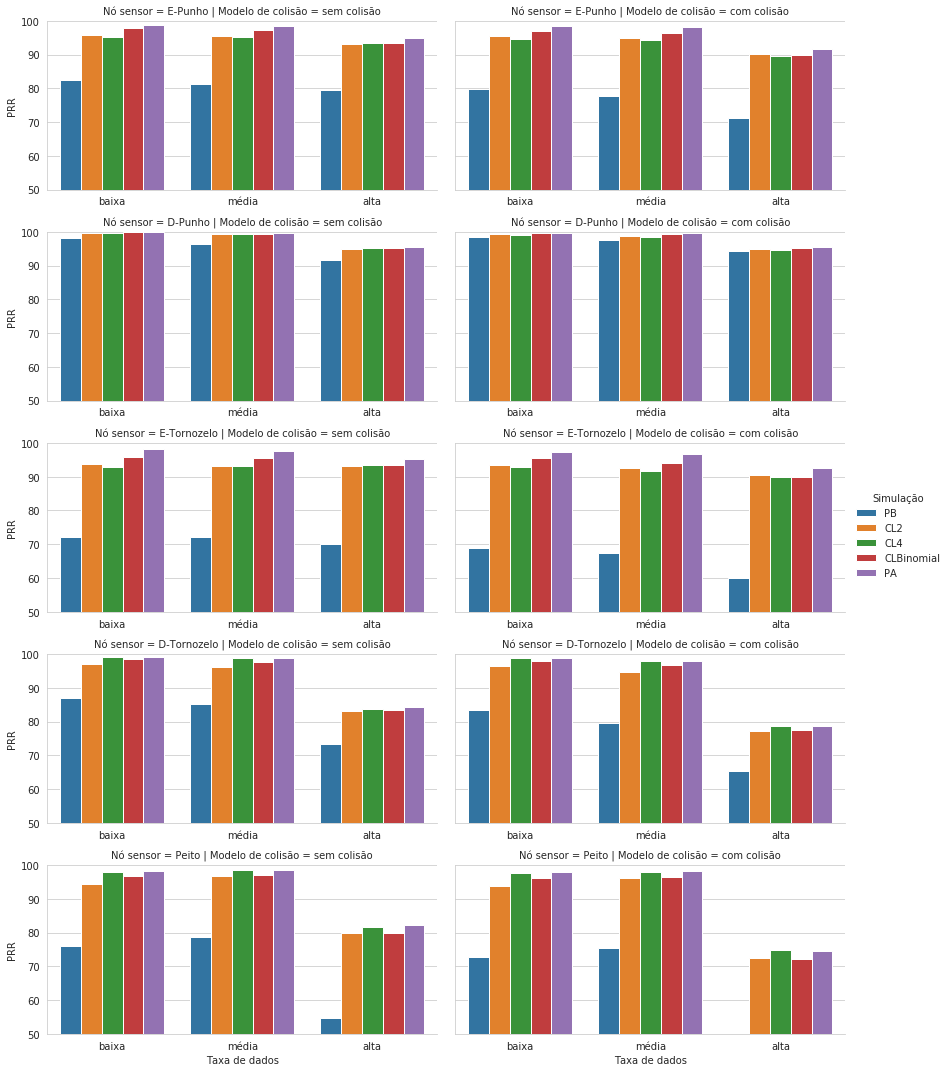

In [20]:
ax = sns.catplot(data=melted_data,
                x='Taxa de dados',
                y='PRR',
                hue='Simulação',
                hue_order=['PB', 'CL2', 'CL4','CLBinomial', 'PA'],
                order=['baixa', 'média', 'alta'],
                col='Modelo de colisão',
                row='Nó sensor',
                kind='bar',
                height=3,
                aspect=2,
#                 ci=None,
                sharex=False,
               )

ax.set(ylim=(50,100))

In [ ]:
#manter padrão dos artigos

In [21]:
melted_data.sample()

,Modelo de colisão,Taxa de dados,Simulação,Nó sensor,PRR
96,sem colisão,alta,PB,D-Tornozelo,73.3


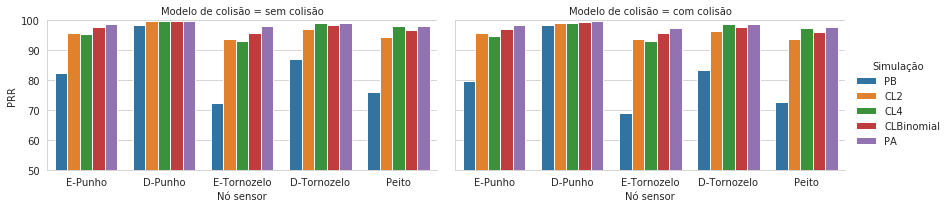

In [22]:
df_baixa = melted_data[melted_data['Taxa de dados'] == 'baixa']

ax = sns.catplot(data=df_baixa,
                 x='Nó sensor',
                 y='PRR',
                 hue='Simulação',
                 hue_order=['PB', 'CL2', 'CL4','CLBinomial', 'PA'],
                 col='Modelo de colisão',
                 kind='bar',
                 height=3,
                 aspect=2,
                )

ax.set(ylim=(50,100))
# ax.set(ylim=(70,100))

In [23]:
del df_baixa

In [24]:
def basic_barchart_PRR(taxa_dados,modelo_colisao,cross_layer_simulation):
    
    select_taxa_dados = melted_data['Taxa de dados'] == taxa_dados
    select_modelo_colisao = melted_data['Modelo de colisão'] == modelo_colisao
    select_potencia = (melted_data['Simulação'] == 'PA') | (melted_data['Simulação'] == 'PB') | (melted_data['Simulação'] == cross_layer_simulation)

    df = melted_data[select_taxa_dados & select_potencia & select_modelo_colisao]


    ax = sns.catplot(data=df,
                     x='Nó sensor',
                     y='PRR',
                     hue='Simulação',
                     hue_order=['PA','PB', cross_layer_simulation],
                     kind='bar',
                     height=3,
                     aspect=2,
                    )

    ax.set(ylim=(50,100)) # Mudar a escala do eixo Y
    ax.set(title=f'Packet Reception Rate - PA PB {cross_layer_simulation}') # para mudar o título do gráfico
    
    return ax



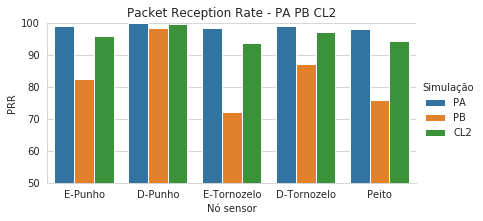

In [25]:
ax = basic_barchart_PRR('baixa','sem colisão', 'CL2')

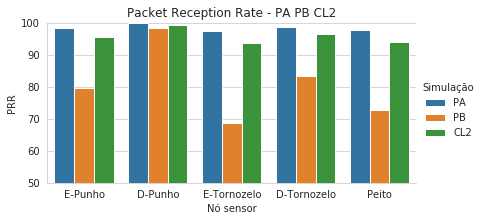

In [26]:
ax = basic_barchart_PRR('baixa','com colisão', 'CL2')

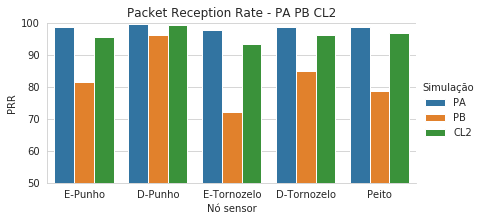

In [27]:
ax = basic_barchart_PRR('média','sem colisão', 'CL2')

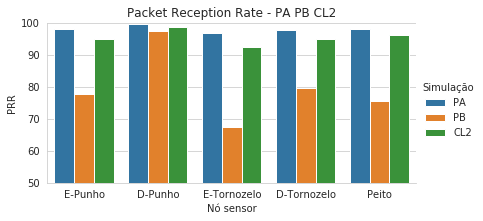

In [28]:
ax = basic_barchart_PRR('média','com colisão', 'CL2')

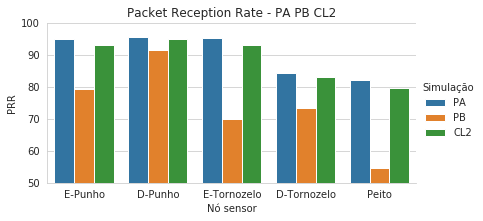

In [29]:
ax = basic_barchart_PRR('alta','sem colisão', 'CL2')

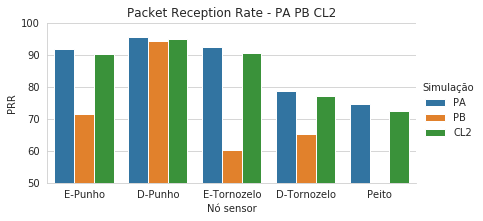

In [30]:
ax = basic_barchart_PRR('alta','com colisão', 'CL2')

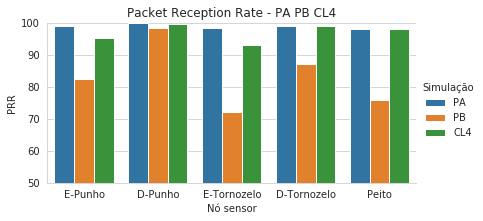

In [31]:
ax = basic_barchart_PRR('baixa','sem colisão', 'CL4')

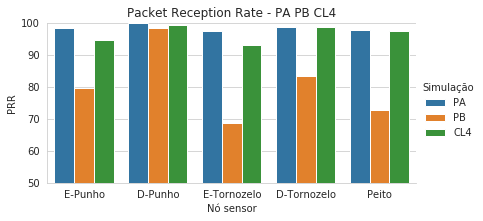

In [32]:
ax = basic_barchart_PRR('baixa','com colisão', 'CL4')

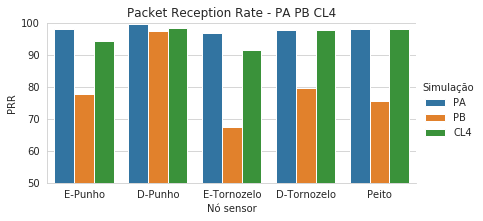

In [33]:
ax = basic_barchart_PRR('média','com colisão', 'CL4')

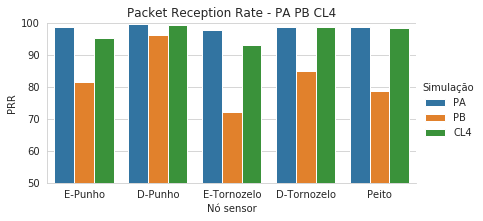

In [34]:
ax = basic_barchart_PRR('média','sem colisão', 'CL4')

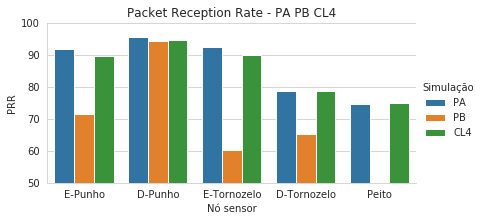

In [35]:
ax = basic_barchart_PRR('alta','com colisão', 'CL4')

# ax.set(ylim=(0,100)) # descomentar linha para mudar escala do eixo Y

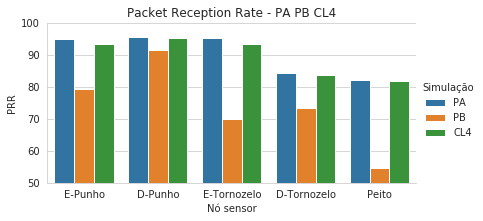

In [36]:
ax = basic_barchart_PRR('alta','sem colisão', 'CL4')

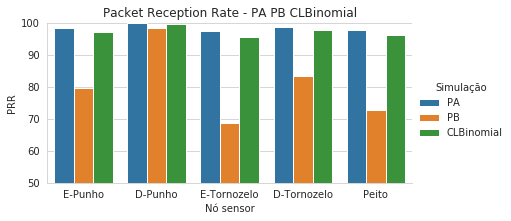

In [37]:
ax = basic_barchart_PRR('baixa','com colisão', 'CLBinomial')

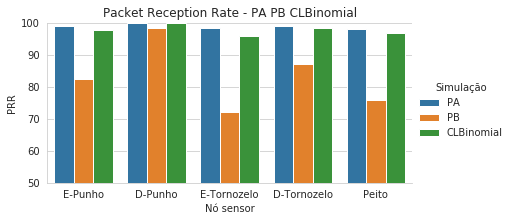

In [38]:
ax = basic_barchart_PRR('baixa','sem colisão', 'CLBinomial')

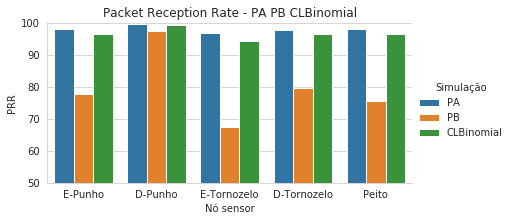

In [39]:
ax = basic_barchart_PRR('média','com colisão', 'CLBinomial')

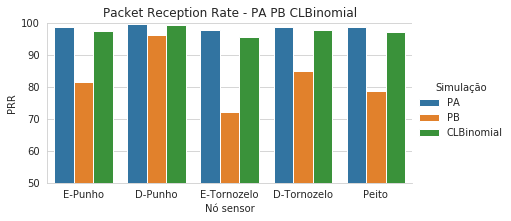

In [40]:
ax = basic_barchart_PRR('média','sem colisão', 'CLBinomial')

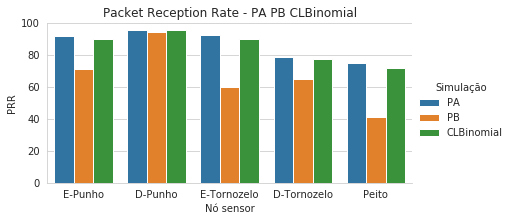

In [41]:
ax = basic_barchart_PRR('alta','com colisão', 'CLBinomial')

ax.set(ylim=(0,100)) # (des)comentar linha para mudar escala Y

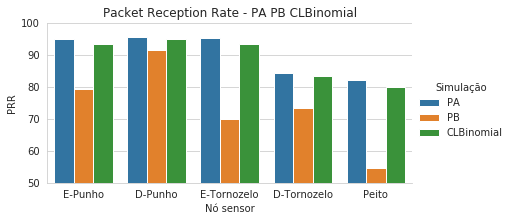

In [42]:
ax = basic_barchart_PRR('alta','sem colisão', 'CLBinomial')